In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

In [3]:
def hist(values, title='', xlabel='Value', bins=200):
    plt.figure(figsize=(15, 5))
    plt.hist(values, bins=bins, log=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.show()

In [4]:
def parts_hist_comparison(a, b, parts, alabel='A', blabel='B', figsize=(15, 25)):
    plt.figure(figsize=figsize)
    for (i, p) in enumerate(parts):
        plt.subplot(len(parts), 2, 2 * i + 1)
        plt.hist(a[p], bins=100, log=True)
        plt.title('{} distribution ({})'.format(p, alabel))
        plt.ylabel('Frequency')
        
        plt.subplot(len(parts), 2, 2 * i + 2)
        plt.hist(b[p], bins=100, log=True)
        plt.title('{} distribution ({})'.format(p, blabel))
        plt.ylabel('Frequency')

    plt.show()

In [5]:
pg = pd.read_csv('postgap.20171113.filtered.txt.gz', sep='\t', na_values=['None'])
print(pg.shape)
pg.head()

/Users/gpeat/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (10,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(31224438, 38)


,ld_snp_rsID,chrom,pos,afr_maf,amr_maf,eas_maf,eur_maf,sas_maf,gene_symbol,gene_id,...,vep_sum,vep_mean,GTEx,VEP,Fantom5,DHS,PCHiC,Nearest,Regulome,VEP_reg
0,rs10740053,10,63702584,0.7784,0.5317,0.6736,0.6928,0.4888,CISD1,ENSG00000122873,...,0.0,0.0,0.0,0.0,0.0,0.0,0.009814,0.0,0.0,0
1,rs10740054,10,63702586,0.7784,0.5317,0.6736,0.6928,0.4877,IPMK,ENSG00000151151,...,0.0,0.0,0.0,0.0,0.0,0.0,0.009814,0.0,0.0,0
2,rs10740053,10,63702584,0.7784,0.5317,0.6736,0.6928,0.4888,IPMK,ENSG00000151151,...,0.0,0.0,0.0,0.0,0.0,0.0,0.009814,0.0,0.0,0
3,rs4506592,10,63727187,0.7020,0.5101,0.6538,0.6511,0.4785,IPMK,ENSG00000151151,...,0.0,0.0,0.0,0.0,0.0,0.0,0.008807,0.0,0.0,0
4,rs11332367,10,63736618,0.8396,0.5303,0.6448,0.6700,0.4826,RTKN2,ENSG00000182010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.007876,0.0,0.0,0


In [ ]:
# ## Issue 1: Abundance of SNPs
# In the GWAS Catalogue data (pre-POSTGAP) currently displayed in the platform, there are approximately 60000 SNPs. POSTGAP brings significantly more (approximately 800000) as can be seen below.
# pk_minus_ld_snp = ['gwas_snp', 'gene_id', 'disease_efo_id', 'gwas_pmid']
# groups = pg.groupby(pk_minus_ld_snp)
# row_counts = groups.size()
# unique_snp_counts = groups['ld_snp_rsID'].nunique()

# print('Number of (lead snp, gene, disease, pmid) groups: {}'.format(row_counts.shape))
# hist(row_counts, title='Histogram of row counts per (lead snp, gene, disease, pmid)', xlabel='Rows associated')
# hist(unique_snp_counts, title='Histogram of unique ld snp counts per (lead snp, gene, disease, pmid)', xlabel='Unique SNPs')

## Issue 2: No data for X, Y chromosomes
The latest POSTGAP file contains no data for SNPs on the X or Y chromosomes and no data for genes on the Y chromosome.

In [6]:
# fields 2, 10 are snp chromosome and gene chromosome respectively
# confirmed with:
#   `gzcat postgap.20171113.filtered.txt.gz | cut -f2 | sort | uniq`
#   `gzcat postgap.20171113.filtered.txt.gz | cut -f10 | sort | uniq`
print('Chromomsomes covered by POSTGAP SNPs: {}'.format(pg.chrom.unique()))
print('Chromomsomes covered by POSTGAP genes: {}'.format(pg.gene_chrom.astype(str).unique()))

Chromomsomes covered by POSTGAP SNPs: [10 12 14  9  7 15  8 11 19  4  3 16  5  6 13  1  2 18 20 22 17 21]
Chromomsomes covered by POSTGAP genes: ['10' '12' '14' '9' '7' '15' '8' '11' '19' '4' '3' '16' '5' '6' '13' '1'
 '2' '18' '20' '22' '17' '21' 'X']


## Issue 3: SNPs and genes on different chromosomes
POSTGAP contains entries where the SNP and gene are on different chromosomes. Is this expected? Should these rows be filtered out?

In [7]:
geo = pg.groupby(['gene_id', 'ld_snp_rsID']).first()
geo = geo[['gene_tss', 'gene_chrom', 'pos', 'chrom']]
chrom_mismatches = (geo.gene_chrom.astype(str) != geo.chrom.astype(str))
print('{} of {} unique gene-SNP pairs have difference between gene and SNP chromosome'.format(chrom_mismatches[chrom_mismatches == True].count(), len(geo)))

2378 of 8226315 unique gene-SNP pairs have difference between gene and SNP chromosome


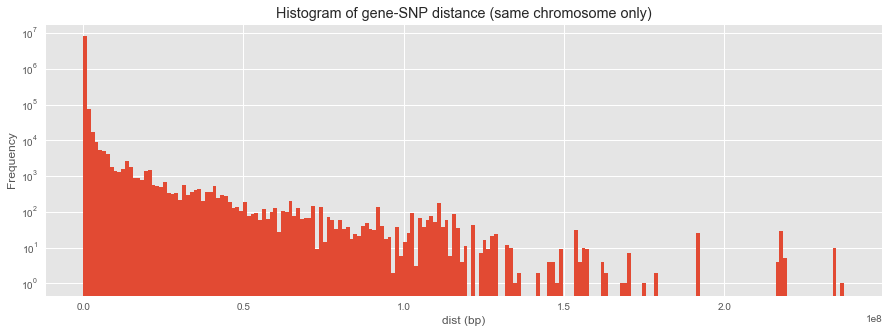

In [8]:
geo_chrom_matches = geo[chrom_mismatches == False]
d = np.absolute(geo_chrom_matches.pos - geo_chrom_matches.gene_tss)
hist(d, title='Histogram of gene-SNP distance (same chromosome only)', xlabel='dist (bp)')

In [9]:
print('{} of {} gene-SNP distances are over 1Mbp apart (when on the same chromosome)'.format(len(d[d > 1000000]), len(d)))
print('{} of {} gene-SNP distances are over 10Mbp apart (when on the same chromosome)'.format(len(d[d > 10000000]), len(d)))
print('{} of {} gene-SNP distances are over 100Mbp apart (when on the same chromosome)'.format(len(d[d > 100000000]), len(d)))

171306 of 8223937 gene-SNP distances are over 1Mbp apart (when on the same chromosome)
25896 of 8223937 gene-SNP distances are over 10Mbp apart (when on the same chromosome)
1144 of 8223937 gene-SNP distances are over 100Mbp apart (when on the same chromosome)


**Question**: Which part(s) of the score contribute to gene-SNP associations with distances over 5Mbp?

In [10]:
far_apart = d[d > 5000000].reset_index(['gene_id', 'ld_snp_rsID'])[['gene_id', 'ld_snp_rsID']]
nearby = d[d <= 5000000].reset_index(['gene_id', 'ld_snp_rsID'])[['gene_id', 'ld_snp_rsID']]

In [11]:
score_parts = ['score', 'VEP', 'Regulome', 'PCHiC', 'GTEx', 'Fantom5', 'DHS', 'Nearest']
far_apart_scores = pd.merge(far_apart, pg[['gene_id', 'ld_snp_rsID', *score_parts]], on=('gene_id', 'ld_snp_rsID'))

In [12]:
nearby_scores = pd.merge(nearby, pg[['gene_id', 'ld_snp_rsID', *score_parts]], on=('gene_id', 'ld_snp_rsID'))

In [13]:
far_apart_scores.head()

,gene_id,ld_snp_rsID,score,VEP,Regulome,PCHiC,GTEx,Fantom5,DHS,Nearest
0,ENSG00000001167,rs34488826,0.0,0.0,0.0,0.009057,0.0,0.0,0.0,0.0
1,ENSG00000001167,rs35147300,0.5,0.0,0.5,0.009057,0.0,0.0,0.0,0.0
2,ENSG00000001167,rs4959235,0.0,0.0,0.0,0.008658,0.0,0.0,0.0,0.0
3,ENSG00000001167,rs71551042,0.5,0.0,0.5,0.009057,0.0,0.0,0.0,0.0
4,ENSG00000001167,rs72098212,0.0,0.0,0.0,0.009057,0.0,0.0,0.0,0.0


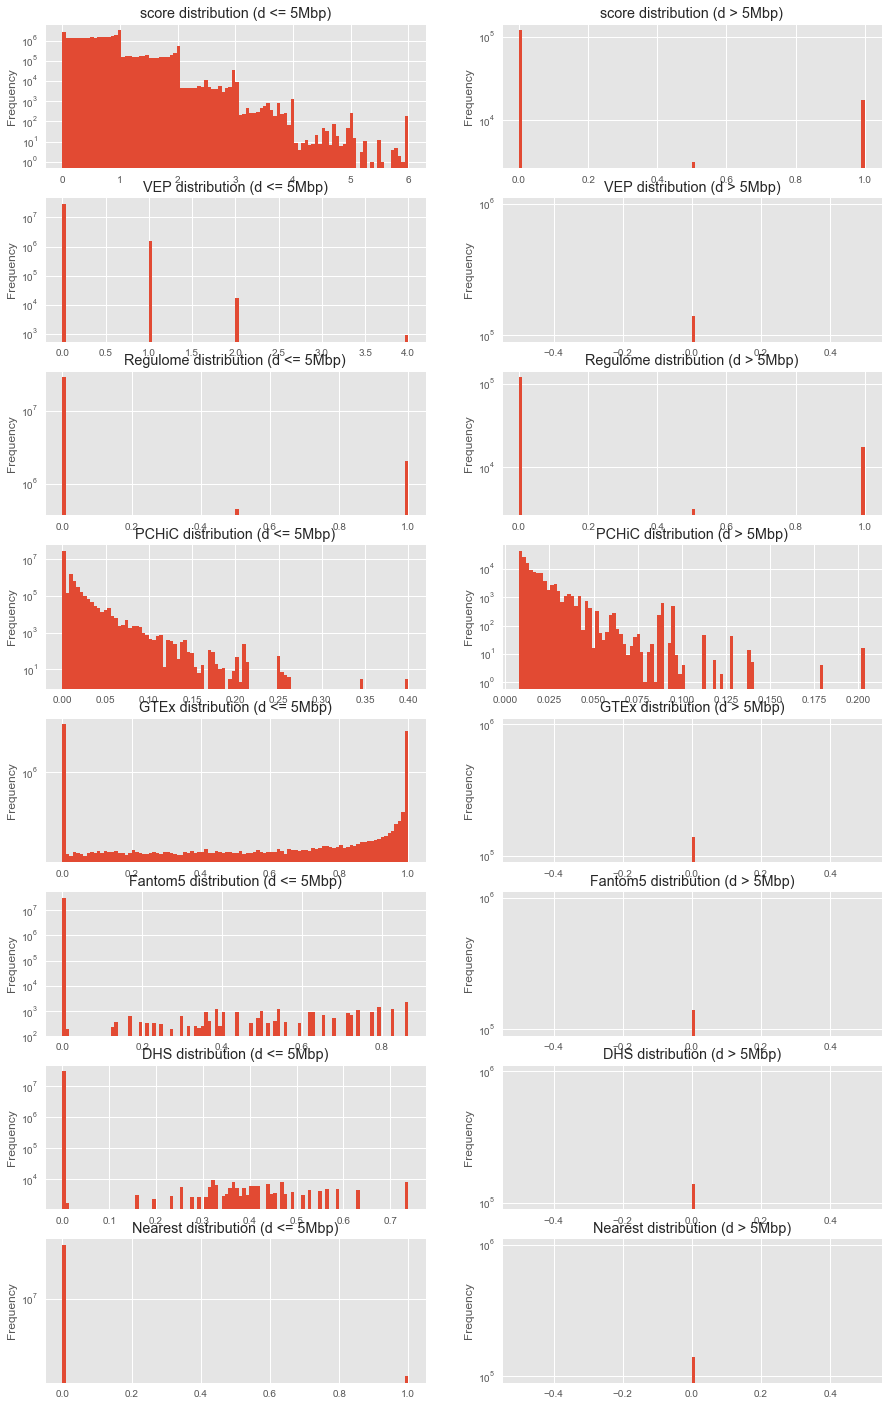

In [14]:
parts_hist_comparison(nearby_scores, far_apart_scores, score_parts, alabel='d <= 5Mbp', blabel='d > 5Mbp')

**Question**: Which part(s) of the score contribute to gene-SNP associations with differing chromosomes?

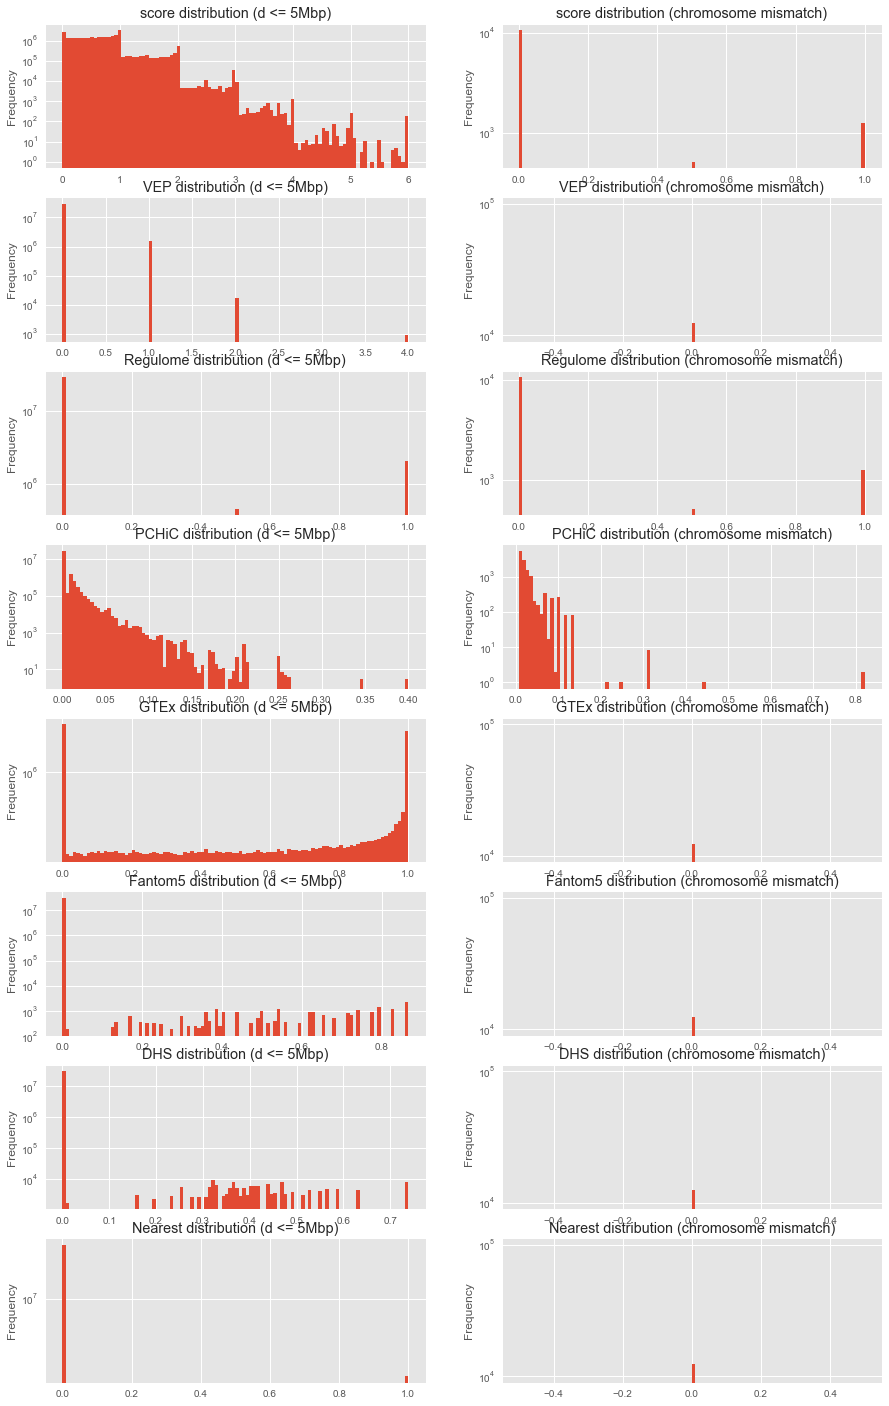

In [15]:
geo_chrom_mismatches = geo[chrom_mismatches == True]
d_mismatches = np.absolute(geo_chrom_mismatches.pos - geo_chrom_mismatches.gene_tss)
chom_mismatch_cols = d_mismatches[d_mismatches > 5000000].reset_index(['gene_id', 'ld_snp_rsID'])[['gene_id', 'ld_snp_rsID']]
chrom_mismatch_scores = pd.merge(chom_mismatch_cols, pg[['gene_id', 'ld_snp_rsID', *score_parts]], on=('gene_id', 'ld_snp_rsID'))
parts_hist_comparison(nearby_scores, chrom_mismatch_scores, score_parts, alabel='d <= 5Mbp', blabel='chromosome mismatch')

## Chromosomal location filtering and scoring cutoff

**Filter**: The rows are to be filtered to keep only those with same gene and SNP chromosome.

**Filter**: The rows are to be filtered to keep only those with gene and SNP less than 1Mbp apart.

The subscores relevant to the Open Targets score are (DHS, Fantom5, PCHiC, GTEx).

**Q**: How are these affected by the two above filters?

**Cutoff**: The Open Targets score may be the maximum of the above four subscores. Applying a low threshold cutoff could reduce the data size.

**Q**: How much data is excluded by different cutoff values?

In [16]:
filtered = pg[(pg.gene_chrom.astype(str) == pg.chrom.astype(str)) & (np.absolute(pg.pos - pg.gene_tss) < 1000000)]

In [17]:
print('Filtered rows: {}\nUnfiltered rows: {}\nPercentage: {}'.format(len(filtered), len(pg), len(filtered) * 100 / len(pg)))

Filtered rows: 30519969
Unfiltered rows: 31224438
Percentage: 97.74385370843184


In [18]:
ot_score_parts = ['PCHiC', 'GTEx', 'Fantom5', 'DHS']
ot_scores = pg.groupby(['gene_id', 'ld_snp_rsID']).first()[ot_score_parts]
ot_scores_filtered = filtered.groupby(['gene_id', 'ld_snp_rsID']).first()[ot_score_parts]

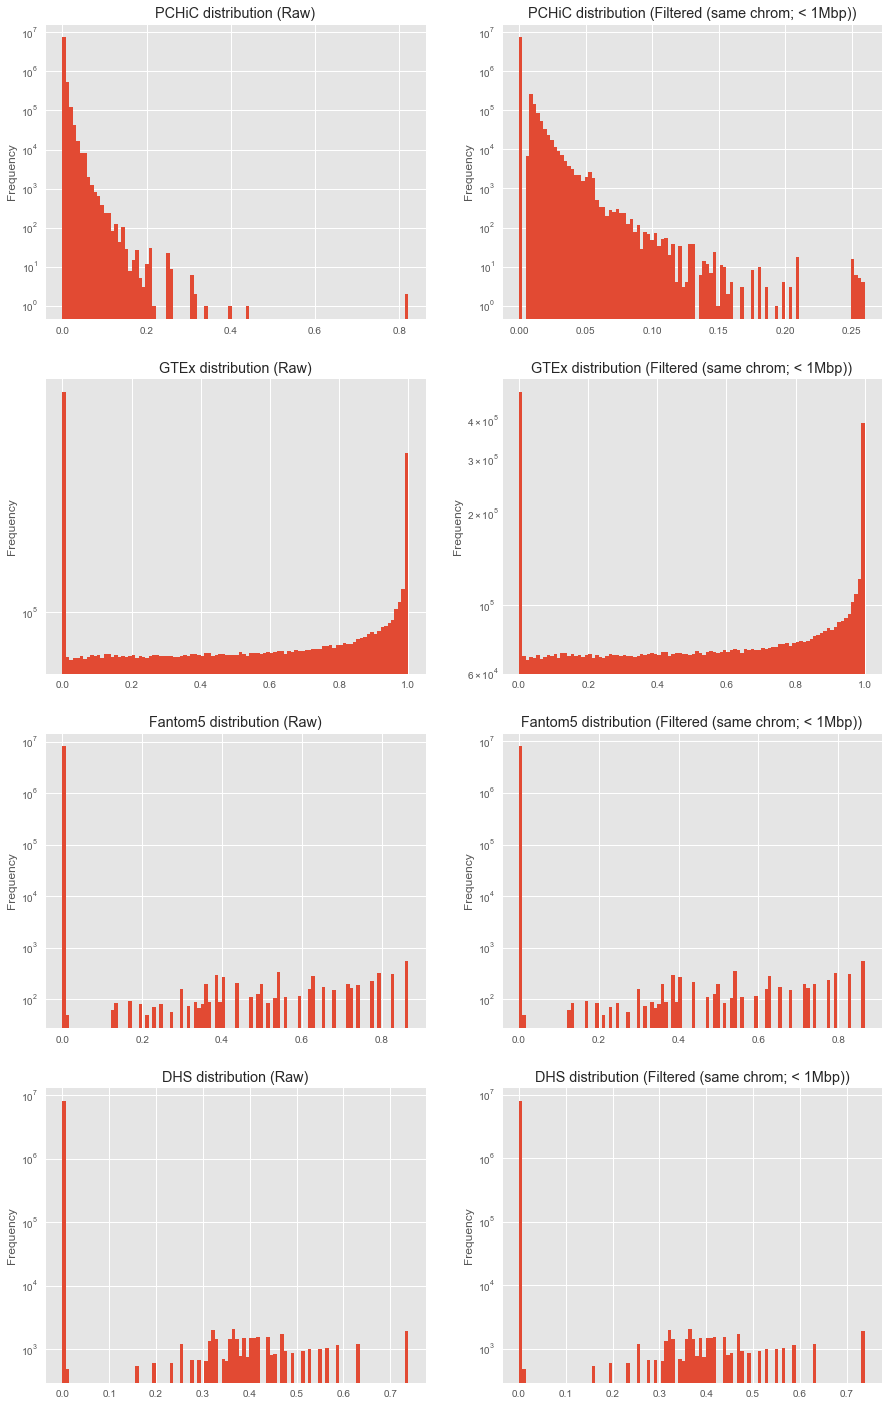

In [19]:
parts_hist_comparison(ot_scores, ot_scores_filtered, ot_score_parts, alabel='Raw', blabel='Filtered (same chrom; < 1Mbp)')

In [20]:
ot_score = ot_scores[ot_score_parts].max(axis=1)
ot_score_filtered = ot_scores_filtered[ot_score_parts].max(axis=1)

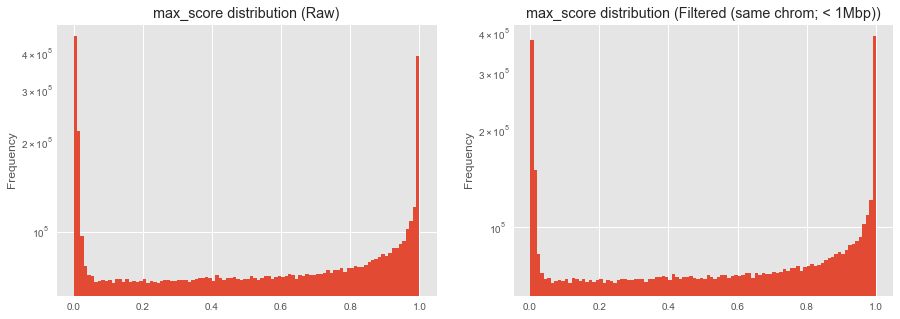

In [21]:
parts_hist_comparison(
    ot_score.to_frame('max_score'),
    ot_score_filtered.to_frame('max_score'),
    ['max_score'],
    alabel='Raw',
    blabel='Filtered (same chrom; < 1Mbp)',
    figsize=(15, 5)
)

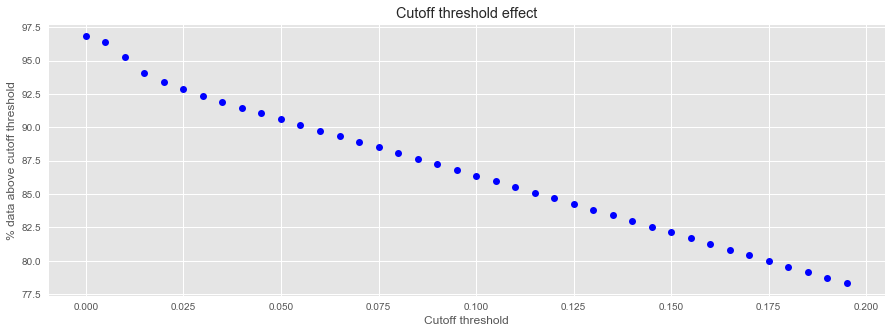

In [22]:
cutoffs = np.arange(0, 0.2, 0.005)
percentages = [len(ot_score_filtered[ot_score_filtered > c]) * 100 / len(ot_score_filtered) for c in cutoffs]
plt.figure(figsize=(15, 5))
plt.plot(cutoffs, percentages, 'bo')
plt.title('Cutoff threshold effect')
plt.xlabel('Cutoff threshold')
plt.ylabel('% data above cutoff threshold')
plt.show()

## What proportion of gene-SNP interactions is dominated by each of the subscores?
If the OT score is taken to be the maximum subscore, which, if any, subscore dominates?

In [23]:
ot_scores_filtered.head()

PCHiC      GTEx  Fantom5  DHS
gene_id         ld_snp_rsID                               
ENSG00000000419 rs1018422      0.0  0.573787      0.0  0.0
                rs1060402      0.0  0.476997      0.0  0.0
                rs11086315     0.0  0.022248      0.0  0.0
                rs1123093      0.0  0.646296      0.0  0.0
                rs112329443    0.0  0.511315      0.0  0.0

In [24]:
# what % of gene-snps have subscore X as the max?
subscore_is_max = ot_scores_filtered.idxmax(axis=1).value_counts()
subscore_is_max_perc = subscore_is_max * 100 / subscore_is_max.sum()
print(subscore_is_max_perc)

GTEx       94.426114
PCHiC       5.325308
DHS         0.210937
Fantom5     0.037640
dtype: float64


In [ ]:
# # what % of gene-snps have subscore X as the max (if pchic is scaled by 4)?
# pchic_big = ot_scores_filtered.copy()
# pchic_big.PCHiC = pchic_big.PCHiC * 4
# subscore_is_max = pchic_big.idxmax(axis=1).value_counts()
# subscore_is_max_perc = subscore_is_max * 100 / subscore_is_max.sum()
# print(subscore_is_max_perc)

In [25]:
# what % of gene-snps have a non-zero subscore X?
subscore_is_nonzero = (ot_scores_filtered > 0).sum()
subscore_is_nonzero_perc = subscore_is_nonzero * 100 / ot_scores_filtered.shape[0]
print(subscore_is_nonzero_perc.sort_values())

Fantom5     0.077056
DHS         0.483271
PCHiC       8.466831
GTEx       94.652898
dtype: float64


In [26]:
# what is the overlap of gene-snp non-zero subscores?
ot_scores_filtered.apply(lambda x: str([c for c in x.index if x[c] > 0]), axis=1).value_counts()

['GTEx']                               7076727
['PCHiC', 'GTEx']                       508703
[]                                      256494
['PCHiC']                               166139
['GTEx', 'DHS']                          26584
['DHS']                                   6175
['PCHiC', 'GTEx', 'DHS']                  4772
['GTEx', 'Fantom5']                       3672
['PCHiC', 'GTEx', 'Fantom5']              1077
['PCHiC', 'DHS']                           824
['Fantom5']                                755
['GTEx', 'Fantom5', 'DHS']                 369
['PCHiC', 'Fantom5']                       140
['PCHiC', 'GTEx', 'Fantom5', 'DHS']        137
['Fantom5', 'DHS']                          45
['PCHiC', 'Fantom5', 'DHS']                 10
dtype: int64

In [72]:
from itertools import combinations
def pairwise_score_hist(scores, parts):
    plt.figure(figsize=(30, 30))
    xrange = np.arange(0, 1, 0.01)
    yrange = np.arange(0, 1, 0.01)
#     plt.title("Subscore comparison across gene-SNP pairs (same chromosome; d < 1Mbp)", fontsize=14)
    for (i, c) in enumerate(combinations(sorted(parts), 2)):
        # calc
        positive_scores = scores[list(c)] # just 2 cols we need
        positive_scores = positive_scores[(positive_scores[c[0]] > 0) & (positive_scores[c[1]] > 0)] # at least one >0
        x = (positive_scores[c[0]])
        y = (positive_scores[c[1]])
        
        # plot
        n = len(score_parts)
        plt.subplot(n, n, (parts.index(c[1]) * n) + parts.index(c[0]) + 1)
#         plt.hist2d(x, y, bins=(100, 100), norm=matplotlib.colors.LogNorm(), cmap=matplotlib.cm.Reds)
        plt.hist2d(x, y, bins=(xrange, yrange), norm=matplotlib.colors.LogNorm(), cmap=matplotlib.cm.Reds)
        plt.ylabel('{}'.format(c[1]))
        plt.xlabel('{}'.format(c[0]))
    plt.tight_layout()
    plt.show()

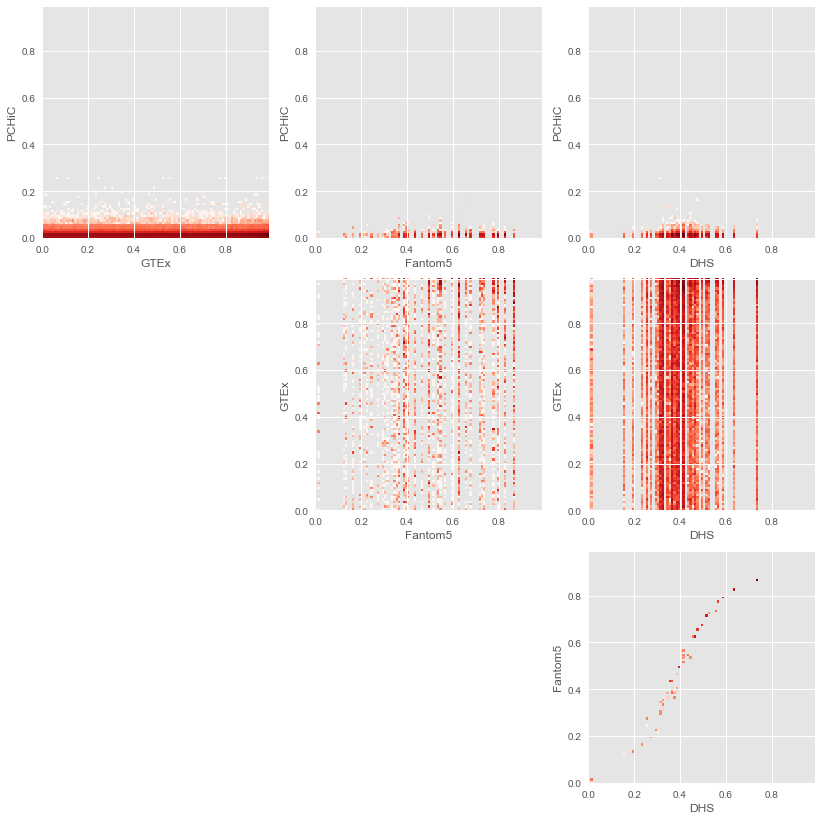

In [73]:
# how do subscores compare for same chromosome and d < 1Mbp?
pairwise_score_hist(ot_scores_filtered, ot_score_parts)

## What happens if GTEx is filtered for 0.8 or above?

In [ ]:
# filter for gtex > 0.8
ot_scores_less_gtex = ot_scores_filtered[ot_scores_filtered.GTEx > 0.8]
print('{} of {} gene-SNP pairs left: {}'.format(
    len(ot_scores_less_gtex),
    len(ot_scores_filtered),
    len(ot_scores_less_gtex) * 100 / len(ot_scores_filtered)
))

In [ ]:
# transform gtex [0.8, 1] => [0, 1]
ot_scores_less_gtex['GTEx_transformed'] = ot_scores_less_gtex['GTEx'].apply(lambda x: (x - 0.8) * 5)
ot_scores_less_gtex.head()
ot_score_parts_less_gtex = ['GTEx_transformed', *[p for p in ot_score_parts if p != 'GTEx']]

In [ ]:
# how do subscores compare if gtex filtered and transformed?
pairwise_score_hist(ot_scores_less_gtex, ot_score_parts_less_gtex)

## All uniform
What happens to subscore to subscore comparisons if each subscore is transformed to a uniform distribution?

In [ ]:
def to_uniform(df, col):
    col_series = df[col].head(500000)
    bins = col_series.sort_values().unique()
    bins = bins[bins > 0]
    col_uniform = col_series.apply(lambda x: (np.digitize(x, bins=bins)) / len(bins))
    return col_uniform

In [ ]:
ot_scores_filtered_uniform = pd.DataFrame({
    (p + '_uniform'): to_uniform(ot_scores_filtered, p) for p in ot_score_parts
})
ot_scores_filtered_uniform.head()

In [ ]:
# how do subscores compare if gtex filtered and transformed?
pairwise_score_hist(ot_scores_filtered_uniform, [(p + '_uniform') for p in ot_score_parts])

In [ ]:
ot_scores_filtered.shape

## Calculating subscore weights
The likely scheme for the OT score is to binarize the subscores (1 if nonzero, 0 otherwise), then produce a weighted sum according to the scheme:

$$
OT Score = \frac{ \sum_{i=1}^{4} I(subscore_{i})w_{i} }{ 4 \sum_{i=1}^{4} w_{i} }
$$

Note: The following transformations should also be applied:
* GTEx subscore will have a cutoff applied at 0.999975
* (PCHiC subscore should be exponentiated and scaled; not relevant due to binarization)

**Q**: How many gene-snp links have a binary signal for each subscore?

In [45]:
# binarize and filter gtex
ot_scores_binary = pd.DataFrame({
    'GTEx': (ot_scores_filtered.GTEx > 0.999975),
    'DHS': (ot_scores_filtered.DHS > 0),
    'Fantom5': (ot_scores_filtered.Fantom5 > 0),
    'PCHiC': (ot_scores_filtered.PCHiC > 0)
})
ot_scores_binary.sum()

DHS         38916
Fantom5      6205
GTEx       118704
PCHiC      681802
dtype: int64

**Q**: What is the overlap of gene-snp non-zero subscores?

In [46]:
ot_scores_binary.apply(lambda x: str([c for c in x.index if x[c] == True]), axis=1).value_counts()

[]                                     7230330
['PCHiC']                               660414
['GTEx']                                102891
['DHS']                                  31792
['GTEx', 'PCHiC']                        14428
['DHS', 'PCHiC']                          5403
['Fantom5']                               4275
['Fantom5', 'PCHiC']                      1167
['DHS', 'GTEx']                            967
['DHS', 'Fantom5']                         398
['DHS', 'GTEx', 'PCHiC']                   193
['Fantom5', 'GTEx']                        152
['DHS', 'Fantom5', 'PCHiC']                140
['Fantom5', 'GTEx', 'PCHiC']                50
['DHS', 'Fantom5', 'GTEx']                  16
['DHS', 'Fantom5', 'GTEx', 'PCHiC']          7
dtype: int64

**Q**: What is the genome coverage of each of the subscores (where appropriate)?

In [48]:
# genome coverage from bedtools; including against alt loci
gencov_full = {
    'DHS': 0.027728,
    'Fantom5': 0.002695,
    'PCHiC': 0.290
}
# genome coverage from bedtools; restrict to 1-22,X,Y,MT chromosomes
gencov_restricted = {
    'DHS': 0.0281,
    'Fantom5': 0.002731,
    'PCHiC': 0.293873
}
# note: no value exists for GTEx, since we only have .bed coverage files for DHS, Fantom5 and PCHiC

## Weighting factors
**Q**: What is the weighting factor for each subscore?

### Numerator
Numerator could be:
* Case A: `|{gwas snp AND (has subscore above cutoff for gwas snp)}| / |{gwas snps}|`
* Case B: `|{gwas snp AND (has subscore above cutoff for any snp in LD)}| / |{gwas snps}|`

### Denominator
Denominator is:

For GTEx: `|{snp AND snp.gtex > 0.999975}| / |{snps analysed in gtex}|`
where `|{snps analysed in gtex}| = 10526813` (see [here](https://www.gtexportal.org/home/documentationPage#staticTextDataProduction))

For non-GTEx: `subscore genome coverage`

In [67]:
# general
gwas_snp_count = pg.gwas_snp.nunique()
gwas_snp_is_ld_snp = pg[pg.ls_snp_is_gwas_snp == True]

In [75]:
# GTEx
gtex = gwas_snp_is_ld_snp[gwas_snp_is_ld_snp.GTEx > 0.999975]
gtex_snp_count = 10526813

gtex_numerator_a = gtex.gwas_snp.nunique() / gwas_snp_count
gtex_numerator_b = pg[pg.GTEx > 0.999975].gwas_snp.nunique() / gwas_snp_count
gtex_denominator = gtex.ld_snp_rsID.nunique() / gtex_snp_count
gtex_factor_a = gtex_numerator_a / gtex_denominator
gtex_factor_b = gtex_numerator_b / gtex_denominator
print('GTEx\nnumerator a: {}\nnumerator b: {}\ndenominator: {}\nfactor a: {}\nfactor b: {}'.format(gtex_numerator_a, gtex_numerator_b, gtex_denominator, gtex_factor_a, gtex_factor_b))

GTEx
numerator a: 0.1035827186512118
numerator b: 0.1464699683877766
denominator: 0.00028014176750361196
factor a: 369.7510713031261
factor b: 522.8423083533522


In [77]:
# Fantom5
fantom5 = gwas_snp_is_ld_snp[gwas_snp_is_ld_snp.Fantom5 > 0]

fantom5_numerator_a = fantom5.gwas_snp.nunique() / gwas_snp_count
fantom5_numerator_b = pg[pg.Fantom5 > 0].gwas_snp.nunique() / gwas_snp_count
fantom5_denominator = gencov_restricted['Fantom5']
fantom5_factor_a = fantom5_numerator_a / fantom5_denominator
fantom5_factor_b = fantom5_numerator_b / fantom5_denominator
print('Fantom5\nnumerator a: {}\nnumerator b: {}\ndenominator: {}\nfactor a: {}\nfactor b: {}'.format(fantom5_numerator_a, fantom5_numerator_b, fantom5_denominator, fantom5_factor_a, fantom5_factor_b))

Fantom5
numerator a: 0.008148928696873902
numerator b: 0.09908675799086758
denominator: 0.002731
factor a: 2.9838625766656546
factor b: 36.28222555505953


In [78]:
# DHS
dhs = gwas_snp_is_ld_snp[gwas_snp_is_ld_snp.DHS > 0]

dhs_numerator_a = dhs.gwas_snp.nunique() / gwas_snp_count
dhs_numerator_b = pg[pg.DHS > 0].gwas_snp.nunique() / gwas_snp_count
dhs_denominator = gencov_restricted['DHS']
dhs_factor_a = dhs_numerator_a / dhs_denominator
dhs_factor_b = dhs_numerator_b / dhs_denominator
print('DHS\nnumerator a: {}\nnumerator b: {}\ndenominator: {}\nfactor a: {}\nfactor b: {}'.format(dhs_numerator_a, dhs_numerator_b, dhs_denominator, dhs_factor_a, dhs_factor_b))

DHS
numerator a: 0.03951527924130664
numerator b: 0.3907973305233579
denominator: 0.0281
factor a: 1.4062376954201652
factor b: 13.907378310439784


In [79]:
# PCHiC
pchic = gwas_snp_is_ld_snp[gwas_snp_is_ld_snp.PCHiC > 0]

pchic_numerator_a = pchic.gwas_snp.nunique() / gwas_snp_count
pchic_numerator_b = pg[pg.PCHiC > 0].gwas_snp.nunique() / gwas_snp_count
pchic_denominator = gencov_restricted['PCHiC']
pchic_factor_a = pchic_numerator_a / pchic_denominator
pchic_factor_b = pchic_numerator_b / pchic_denominator
print('PCHiC\nnumerator a: {}\nnumerator b: {}\ndenominator: {}\nfactor a: {}\nfactor b: {}'.format(pchic_numerator_a, pchic_numerator_b, pchic_denominator, pchic_factor_a, pchic_factor_b))

PCHiC
numerator a: 0.40379346680716544
numerator b: 0.6447839831401475
denominator: 0.293873
factor a: 1.3740407142104427
factor b: 2.194090587226957


## GWAS and LD SNP overlap
**Q**: Does every GWAS SNP have an `ls_snp_is_gwas_snp==True` row?

In [53]:
has_self_as_ld_snp = pg.groupby('gwas_snp')['ls_snp_is_gwas_snp'].any()
has_self_as_ld_snp[has_self_as_ld_snp == False]

gwas_snp
rs1010553      False
rs10683220     False
rs116445074    False
rs140658666    False
rs140824699    False
rs141512860    False
rs142496819    False
rs143046984    False
rs144503462    False
rs184060364    False
rs1905376      False
rs201045437    False
rs2269188      False
rs2303566      False
rs2429928      False
rs547065676    False
rs56235845     False
rs568645819    False
rs57675369     False
rs5794958      False
rs5822105      False
rs59901009     False
rs6124760      False
rs6442310      False
rs71378803     False
Name: ls_snp_is_gwas_snp, dtype: bool